The molecular dynamics pipeline: from crystal structure to simulation to analysis
-------

### Warm-Up Exercises
- 🤨 Try reading the PDB file containing alanine dipeptide and see if you can
dissect the rôles of different sections.
- 🩺 Study the biomedical importance of human neutrophil elastate.
- 💎 Could you find a crystal structure for HNE? What's different between this
and alanine dipeptide except the protein size?

You have just completed your first simulation on a somewhat toyish system, alanine dipeptide,
and are more or less familiar with the necessary complnents of MD.
In this notebook, we simulate a real system of real biomedical modeling significance---
human neutrophil elastate (HNE), and show you the pipeline from a raw
crystal structure to the simulation to downstream analysis.

In [38]:
import openmm
from openmm import app, unit
import urllib

If you haven't secured a crystal structure for HNE, use this one below:

In [39]:
urllib.request.urlretrieve(
    "https://files.rcsb.org/view/2Z7F.pdb",
    "2Z7F.pdb"
)

('2Z7F.pdb', <http.client.HTTPMessage at 0x1af101a30>)

### Structure preparation

In the last notebook, we have used a perfectly clean PDB file as our starting
point.
We don't always have this luxury---in real life, PDB files come with werid
protonation states, crystal waters, and non-standard residues.
Luckily, `pdbfixer` can fix many of these situations.

In [40]:
from pdbfixer import PDBFixer
fixer = PDBFixer("2Z7F.pdb")
fixer.removeHeterogens(True)
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()
fixer.addMissingHydrogens(7.0)

If you had been a user of a more traditional MD simulation package, you'll
realize that this is as a matter of fact a lot simpler.

What should be the force field to specify for the protein and the water molecules?

In [ ]:
#NOTE: HIDDEN
forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

Now we transfer the structure to the `Modeler`, also defined in the `app` layer
in `OpenMM`, and take care of the hydrogens and solvents.

In [42]:
modeler = app.Modeller(fixer.topology, fixer.positions)
modeler.addHydrogens(forcefield=forcefield, pH=7.0)
modeler.addSolvent(forcefield=forcefield, padding=1.0*unit.nanometers)

For now on, you should be able to run the simulation and save the output to `output.pdb`,
following the instructions from previous notebook.

💡Hint:
Now the `topology` and `position` are _attributes_ of the `modeler`.

In [ ]:
#NOTE: HIDDEN
system = forcefield.createSystem(
    modeler.topology, 
    nonbondedMethod=app.PME,
    nonbondedCutoff=1*unit.nanometer, 
    constraints=app.HBonds,
)

In [44]:
#NOTE: HIDDEN
integrator = openmm.LangevinIntegrator(
    300*unit.kelvin, 
    1.0/unit.picoseconds, 
    2.0*unit.femtoseconds,
)

In [45]:
#NOTE: HIDDEN
simulation = app.Simulation(modeler.topology, system, integrator)

Now it's time to put the positions in the PDB file into the simulation.

In [46]:
#NOTE: HIDDEN
simulation.context.setPositions(modeler.positions)

At this point, you can safely minimize the energy like before.

In [47]:
#NOTE: HIDDEN
simulation.minimizeEnergy()

We will output the trajectory as a PDB file for easy viewing, as well as a DCD reporter for future analysis.

In [48]:
simulation.reporters.append(app.PDBReporter('output.pdb', 100))
simulation.reporters.append(app.DCDReporter('output.dcd', 50))

Let's also add some reporters so we can see if our simulation was stable.

In [49]:
log_freq = 50
simulation.reporters.append(app.StateDataReporter(open('log.hne', 'w'),
                                              log_freq, 
                                              step=True,
                                              potentialEnergy=True,
                                              kineticEnergy=True,
                                              totalEnergy=True,
                                              temperature=True,
                                              volume=True,
                                              density=True,
                                              speed=True))

In [50]:
#write out modeler to a pdb file (useful for analysis)
app.PDBFile.writeFile(
    modeler.topology, 
    modeler.positions, 
    open('first-frame.pdb', 'w')
)

In [51]:
simulation.step(10000)

We can check that our simulation was stable using a number of quick checks. First lets just load in our trajectory:

In [52]:
import mdtraj as md
traj = md.load('output.pdb')

Like before, we will use MDTraj to quickly see if the RMSD of the backbones stabilized, indicative of a degree of equilibration.

Text(0, 0.5, 'RMSD (nm)')

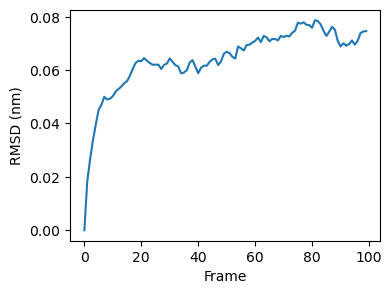

In [55]:
#NOTE: HIDDEN
from matplotlib import pyplot as plt
rmsd = md.rmsd(traj, traj, atom_indices=traj.topology.select('backbone'))
plt.figure(figsize=(4, 3))
plt.plot(rmsd)
plt.xlabel('Frame')
plt.ylabel('RMSD (nm)')

We will use MDTraj moreso later in `analyze-simulation.ipynb` but for the moment it appears that the simulation relaxes from the first structure within the first 10-20 frames.

We can also load in the `log.hne` file, which contains our energies and other interesting parameters and make plots of them!
For example:

In [59]:
import pandas as pd
log_vals = pd.read_csv('log.hne')

Text(0.5, 0, 'Step')

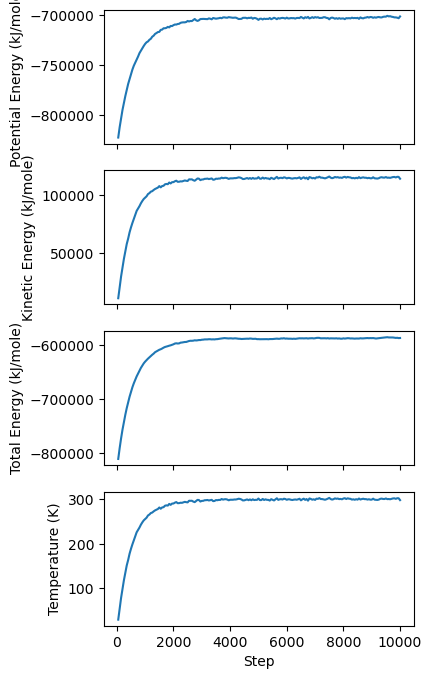

In [73]:
# make a plot with three subplots, one for each energy
fig, axes = plt.subplots(4, 1, figsize=(4, 8), sharex=True)
for i, col in enumerate(['Potential Energy (kJ/mole)', 'Kinetic Energy (kJ/mole)', 'Total Energy (kJ/mole)', 'Temperature (K)']):
    axes[i].plot(log_vals['#"Step"'], log_vals[col])
    axes[i].set_ylabel(col)
axes[-1].set_xlabel('Step')



We can plot other properties as well to ensure things remain where we expect at equilibration, such as Temperature and density!

Text(0.5, 0, 'Step')

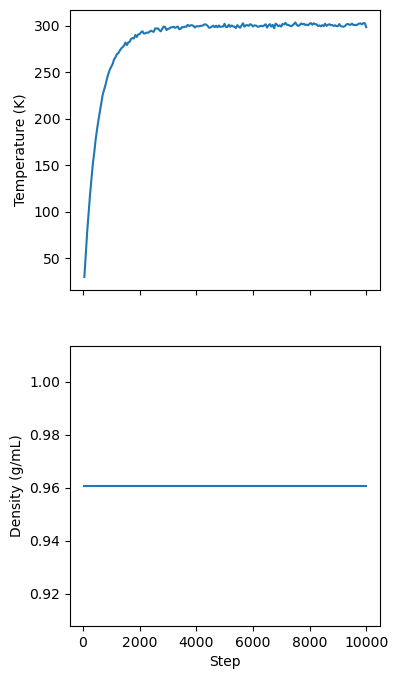

In [75]:
# make a plot with three subplots, one for each energy
fig, axes = plt.subplots(2, 1, figsize=(4, 8), sharex=True)
for i, col in enumerate(['Temperature (K)', 'Density (g/mL)']):
    axes[i].plot(log_vals['#"Step"'], log_vals[col])
    axes[i].set_ylabel(col)
axes[-1].set_xlabel('Step')

### Take-home exercises
- Now that you've completed the simulation for the HNE protein, you are about to be able to complete it for any protein of your choice! Repeat the exercise for a protein structure predicted by [`AlphaFold`](https://www.alphafold.ebi.ac.uk) and note any difference in the experience.
- Can you now do so for a protein that might be of interest in your research?